# **BitePulse AI - Modeling - TCN**

* **Name/Group:** Aktham Almomani / Group 13

## **Introduction**

In this notebook, we'll train 2 working bite detector: a Pose-only Temporal ConvNet (TCN) & RGB 3D-CNN (video frames) that predict "intake vs. not-intake" on fixed windows, logs accuracy/precision/recall, and captures quick error notes (chewing FPs, missed-bite FNs, angle/occlusion issues):

* Train the these classifiers on windowed data to predict intake vs not-intake.
* Log metrics: accuracy, precision, recall at the window level.
* Error analysis: inspect classic failure modes; FPs where chewing looked like intake, FNs (missed bites), and any angles/occlusions that hurt performance.
* Label-rule iteration: if needed, tweak how we define/merge very-close intake events (this sets us up for counting and pacing next)

## **Data**

Our input will be the artifacts we finalized at proveious Feature pipeline notebook:

* Manifest w/ splits: labels_v1/manifest_with_split.parquet (keys, paths, split).
* Per-frame labels: labels_v1/frames_idx.parquet (key, split, frame, time_sec, label).
* Event segments: labels_v1/segs_idx.parquet (key, split, start_sec, end_sec, label).
These are the artifacts we finalized at the end of Week 2; the notebook will load them directly.



## **Models Selctions**

In this notebook, we'll train two temporal baselines in parallel and compare them on the same windows/splits:

* Pose-only Temporal ConvNet (TCN):

  * Input: for each window, a pose tensor of shape (T, JxD) (upper-body joints over T frames).
  * Backbone: stacks of 1D temporal conv blocks (+ norm + dropout) over time.
  * Head: global temporal pooling &rarr; sigmoid (binary: intake vs not).
  * Pros: fast, privacy-friendly, robust to lighting/background.

* RGB 3D-CNN (video frames):

  * Input: a clip tensor (T, H, W, C) per window (lightly augmented).
  * Backbone: compact 3D conv stem (or 2D conv + temporal pooling).
  * Head: global spatiotemporal pooling &rarr; sigmoid (binary).
  * Pros: captures appearance cues (cup/straw/utensils) helpful for bite-vs-sip later.

* Training parity

  * Same windows, subject-wise splits, optimizer/schedule, class weighting, and early stopping.
  * Log: loss, accuracy, precision, recall (window-level).

* Evaluation & comparison

  * Primary: window precision/recall/F1 on the validation set.
  * Secondary: quick eventization of positives to eyeball event-level precision/recall on a subset.
  * Error notes: FPs (chewing/fidgets), FNs (occlusions, fast sips), angle/lighting issues.

* Decision rule

  * If TCN &asymp; 3D-CNN (&plusmn;1-2 F1 pts), pick TCN for simplicity/latency.
  * If 3D-CNN is clearly better (&ge;3 F1 pts or fewer type confusions), keep it or plan a late-fusion model (TCN + light RGB) next week.

## **Imports and basic setup**

In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pyarrow
import os, sys, math, json, time, random, contextlib, logging, re, subprocess, math
from pathlib import Path
from typing import Dict, Any, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision.transforms import functional as TF
from torchvision import transforms
from sklearn.metrics import (
    precision_recall_curve, roc_curve, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,
    classification_report, balanced_accuracy_score, matthews_corrcoef, auc
)
from sklearn.preprocessing import label_binarize
from scipy.special import expit as sigmoid
from tqdm.auto import tqdm
from contextlib import nullcontext

## **Paths setup**

Here's let's define our exact folders on Drive.

In [ ]:
# Paths & Config:
ROOT       = Path("/content/drive/MyDrive/eatsense")
DATA_DIR   = ROOT                         # raw data root:pose/frames
LABELS_DIR = ROOT / "labels_v1"           # manifest_with_split.parquet, frames_idx.parquet, segs_idx.parquet
POSE_DIR   = ROOT / "true2d_parquet"      # per-video 2D pose parquet files
FRAMES_DIR = ROOT / "frames"              # RGB frames per video
CKPT_DIR   = ROOT / "checkpoints"
LOG_DIR    = ROOT / "logs"

# Create writable dirs:
for d in [CKPT_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [ ]:
# Quick sanity checks:
need = [LABELS_DIR / "manifest_with_split.parquet",
        LABELS_DIR / "frames_idx.parquet",
        LABELS_DIR / "segs_idx.parquet",
        POSE_DIR]
missing = [str(p) for p in need if not Path(p).exists()]
if missing:
    print("Missing expected paths/files:\n - " + "\n - ".join(missing))
else:
    print("Paths OK")

print(f"ROOT={ROOT}\nLABELS_DIR={LABELS_DIR}\nPOSE_DIR={POSE_DIR}\nFRAMES_DIR={FRAMES_DIR}\nCKPT_DIR={CKPT_DIR}\nLOG_DIR={LOG_DIR}")

Paths OK
ROOT=/content/drive/MyDrive/eatsense
LABELS_DIR=/content/drive/MyDrive/eatsense/labels_v1
POSE_DIR=/content/drive/MyDrive/eatsense/true2d_parquet
FRAMES_DIR=/content/drive/MyDrive/eatsense/frames
CKPT_DIR=/content/drive/MyDrive/eatsense/checkpoints
LOG_DIR=/content/drive/MyDrive/eatsense/logs


## **Helpers**

In [ ]:
# CONFIG:
CONFIG: Dict[str, Any] = {
    "seed": 1981,
    "num_workers": 2,
    "pin_memory": True,
    "persistent_workers": True,
    # windowing
    "win_sec": 0.5,
    "stride_sec": 0.25,
    # training
    "epochs": 12,
    "batch_size": 32,
    "lr": 3e-4,
    "weight_decay": 1e-5,
    "pos_class_weight": 1.5,   # to handle class imbalance
    "amp": True,               # enable mixed precision
    "amp_dtype": "bf16",       # "bf16" for A100 GPU
    # eval
    "pred_thresh": 0.5,
}

# Reproducibility & Device:
def set_seed(seed: int = 1981):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE.type} | Torch: {torch.__version__} | Torchvision: {torchvision.__version__}")

# Logging:
def get_logger(name="bitepulse", level=logging.INFO, log_file: Optional[Path] = LOG_DIR / "run.log"):
    logger = logging.getLogger(name)
    if logger.handlers:
        return logger
    logger.setLevel(level)
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")
    sh = logging.StreamHandler(stream=sys.stdout); sh.setFormatter(fmt); logger.addHandler(sh)
    if log_file:
        fh = logging.FileHandler(log_file); fh.setFormatter(fmt); logger.addHandler(fh)
    return logger

LOGGER = get_logger()

# Metric helper (window-level):
@torch.no_grad()
def bin_metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, thresh: float = 0.5) -> Dict[str, float]:
    """logits: (N,) raw logits; targets: (N,) {0,1}"""
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).to(targets.dtype)

    tp = (preds.eq(1) & targets.eq(1)).sum().item()
    fp = (preds.eq(1) & targets.eq(0)).sum().item()
    fn = (preds.eq(0) & targets.eq(1)).sum().item()
    tn = (preds.eq(0) & targets.eq(0)).sum().item()

    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

# Simple running average:
class SmoothedValue:
    def __init__(self): self.n, self.total = 0, 0.0
    def update(self, val, cnt=1): self.total += float(val) * cnt; self.n += cnt
    @property
    def avg(self): return self.total / max(self.n, 1)

# AMP (A100-GPU):

def make_amp_ctx():
    if not CONFIG["amp"] or DEVICE.type != "cuda":
        return nullcontext
    if CONFIG.get("amp_dtype", "bf16") == "bf16":
        return lambda: torch.amp.autocast("cuda", dtype=torch.bfloat16)
    else:  # "fp16"
        return lambda: torch.amp.autocast("cuda", dtype=torch.float16)

AMP_CTX = make_amp_ctx()
SCALER  = (torch.amp.GradScaler('cuda')
           if (CONFIG["amp"] and CONFIG.get("amp_dtype","bf16") == "fp16") else None)

# Save config snapshot:
with open(LOG_DIR / "config.json", "w") as f:
    json.dump({
        "paths": {
            "ROOT": str(ROOT), "DATA_DIR": str(DATA_DIR), "LABELS_DIR": str(LABELS_DIR),
            "CKPT_DIR": str(CKPT_DIR), "LOG_DIR": str(LOG_DIR)
        },
        "train": CONFIG
    }, f, indent=2)


Device: cuda | Torch: 2.8.0+cu126 | Torchvision: 0.23.0+cu126


## **Data & Window Index**

We load the labeling artifacts, slice each video into `fixed windows` (win_sec, stride_sec), and label each window by IoU overlap with intake segments. The result is a single `windows_idx.parquet` we'll use for both models. Then we define two minimal datasets: `PoseWindowDataset` (for TCN) and `RGBClipDataset` (for 3D-CNN), both reading from the same windows_idx.

**Inputs expected (already in LABELS_DIR):**

* `manifest_with_split.parquet` (columns like: `key`, `split`, `fps`, `n_frames`)
* `frames_idx.parquet` (per-frame timing; we only need `key` and duration or `time_sec`)
* `segs_idx.parquet` (intake segments with `start_sec`, `end_sec`, `label` where label==1 means intake)
* Pose parquet per video under DATA_DIR / `"true2d_parquet" / f"{key}.parquet"` (must include `time_sec` + numeric joint columns)
* RGB frames per video under `DATA_DIR / "frames" / key / *.jpg` (named like `000001.jpg`, etc.)



In [ ]:
# config tweaks:
CONFIG["win_sec"] = 2.0
CONFIG["stride_sec"] = 0.5
CONFIG["pos_class_weight"] = 2.0   # for imbalance

INTAKE_LABELS = {"Eat it"}   # positive labels in segs_idx
WINDOW_POS_OVERLAP = 0.25    # window is positive if IoU with any intake segment >= this

# Load artifacts:
MANIFEST_PATH   = LABELS_DIR / "manifest_with_split.parquet"
FRAMES_IDX_PATH = LABELS_DIR / "frames_idx.parquet"
SEGS_IDX_PATH   = LABELS_DIR / "segs_idx.parquet"
for p in [MANIFEST_PATH, FRAMES_IDX_PATH, SEGS_IDX_PATH]:
    assert p.exists(), f"Missing: {p}"

In [ ]:
manifest  = pd.read_parquet(MANIFEST_PATH)
frames_ix = pd.read_parquet(FRAMES_IDX_PATH)
segs_ix   = pd.read_parquet(SEGS_IDX_PATH)

# Derive/confirm time column:
_time_col = "time_sec" if "time_sec" in frames_ix.columns else None
if _time_col is None and {"frame","fps"}.issubset(frames_ix.columns):
    frames_ix = frames_ix.copy()
    frames_ix["time_sec"] = frames_ix["frame"] / frames_ix["fps"]
    _time_col = "time_sec"
assert _time_col is not None, "frames_idx must have time_sec or (frame,fps)."

# Keep only intake segments:
if "label" in segs_ix.columns:
    if segs_ix["label"].dtype.kind in "iu":
        segs_pos = segs_ix[segs_ix["label"].astype(int) == 1].copy()
    else:
        segs_pos = segs_ix[segs_ix["label"].astype(str).isin(list(INTAKE_LABELS))].copy()
else:
    segs_pos = segs_ix.copy()

In [ ]:
# Build fixed windows and label by IoU:
WIN_SEC  = float(CONFIG["win_sec"])
STRIDE_S = float(CONFIG["stride_sec"])

def _dur(key: str) -> float:
    f = frames_ix[frames_ix["key"] == key]
    return float(f[_time_col].max()) if len(f) else 0.0

def _iou(a0, a1, b0, b1) -> float:
    inter = max(0.0, min(a1, b1) - max(a0, b0))
    if inter <= 0: return 0.0
    union = (a1 - a0) + (b1 - b0) - inter + 1e-9
    return inter / union

def _label_window(key: str, w0: float, w1: float) -> int:
    s = segs_pos[segs_pos["key"] == key]
    if s.empty:
        return 0
    ious = s.apply(lambda r: _iou(w0, w1, float(r["start_sec"]), float(r["end_sec"])), axis=1).to_numpy()
    return int((ious >= WINDOW_POS_OVERLAP).any())

rows = []
for key, g in manifest.groupby("key"):
    split = g["split"].iloc[0] if "split" in g.columns else "train"
    dur = _dur(key)
    if dur <= 0:
        continue
    t = 0.0
    while t + WIN_SEC <= dur + 1e-6:
        w0, w1 = t, t + WIN_SEC
        rows.append((key, split, w0, w1, _label_window(key, w0, w1)))
        t += STRIDE_S

windows_df = pd.DataFrame(
    rows, columns=["key","split","start_sec","end_sec","label"]
).astype({"key":"string","split":"string","start_sec":"float32","end_sec":"float32","label":"int8"})

out_path = LOG_DIR / "windows_idx.parquet"
windows_df.to_parquet(out_path)
cnt = windows_df.value_counts("split").to_dict()
pos_rate = float((windows_df["label"]==1).mean()) if len(windows_df) else 0.0
LOGGER.info(f"windows_idx saved: {out_path} | rows={len(windows_df)} | by split={cnt} | pos_rate={pos_rate:.3f}")

2025-11-19 00:25:22,549 | INFO | windows_idx saved: /content/drive/MyDrive/eatsense/logs/windows_idx.parquet | rows=98582 | by split={'train': 62568, 'val': 21184, 'test': 14830} | pos_rate=0.006


INFO:bitepulse:windows_idx saved: /content/drive/MyDrive/eatsense/logs/windows_idx.parquet | rows=98582 | by split={'train': 62568, 'val': 21184, 'test': 14830} | pos_rate=0.006


In [ ]:
# Pose windows for TCN:
class PoseWindowDataset(Dataset):
    """
    Expects pose parquet at POSE_DIR / '{key}.parquet' with 'time_sec' + numeric joint columns.
    """
    def __init__(self, windows: pd.DataFrame, fps: float = 30.0, cols_regex: str = r"^(x_|y_|z_|j\d+)"):
        self.df = windows.reset_index(drop=True)
        self.fps = float(fps)
        self.T   = max(1, int(round(CONFIG["win_sec"] * self.fps)))
        self._re = re.compile(cols_regex)
        self._cache = {}

    def _pose_df(self, key: str) -> pd.DataFrame:
        if key in self._cache:
            return self._cache[key]
        p = POSE_DIR / f"{key}.parquet"
        df = pd.read_parquet(p)
        assert "time_sec" in df.columns, "pose parquet must include 'time_sec'."
        cols = [c for c in df.columns if c!="time_sec" and pd.api.types.is_numeric_dtype(df[c]) and self._re.search(str(c))]
        if not cols:
            cols = [c for c in df.columns if c!="time_sec" and pd.api.types.is_numeric_dtype(df[c])]
        df = df[["time_sec"] + cols]
        self._cache[key] = df
        return df

    def _slice(self, key: str, w0: float, w1: float) -> torch.Tensor:
      df = self._pose_df(key)
      m  = (df["time_sec"] >= w0) & (df["time_sec"] < w1)
      clip = df.loc[m].drop(columns=["time_sec"]).to_numpy(dtype=np.float32)

      # Handle empty / bad values:
      if clip.size == 0:
          F = len(df.columns) - 1
          arr = np.zeros((self.T, F), dtype=np.float32)
      else:
          # replace NaN/Inf before sampling:
          clip = np.nan_to_num(clip, nan=0.0, posinf=0.0, neginf=0.0)
          idx = np.linspace(0, max(len(clip)-1, 0), num=self.T).round().astype(int)
          arr = clip[idx]

      # per-window z-score with safe denom:
      if arr.size:
          mu = arr.mean(0, keepdims=True)
          sd = arr.std(0, keepdims=True)
          sd = np.where(sd < 1e-6, 1e-6, sd)
          arr = (arr - mu) / sd

      arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
      return torch.from_numpy(arr)


    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        x = self._slice(r["key"], float(r["start_sec"]), float(r["end_sec"]))
        y = torch.tensor(int(r["label"]), dtype=torch.long)
        return x, y

def collate_pose(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs, dim=0), torch.tensor(ys, dtype=torch.long)

## **Baseline TCN model (pose-only) + train/val loop**

Here, let's:

* Define a temporal ConvNet that takes (B, T, F) pose windows.
* Train it as binary classifier (intake vs not) with class weight.
* Logs loss + accuracy/precision/recall/F1 on train and val.


In [ ]:
# TCN backbone:
class Chomp1d(nn.Module):
    def __init__(self, chomp): super().__init__(); self.chomp = chomp
    def forward(self, x): return x[..., :-self.chomp] if self.chomp > 0 else x

class SE1D(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(ch, ch // r, 1), nn.GELU(),
            nn.Conv1d(ch // r, ch, 1), nn.Sigmoid()
        )
    def forward(self, x): return x * self.fc(x)

class DSConv1D(nn.Module):
    """Depthwise-separable conv + LayerNorm + GELU."""
    def __init__(self, in_ch, out_ch, k=5, d=1, causal=True, p_drop=0.2):
        super().__init__()
        pad = (k - 1) * d if causal else ((k - 1) * d) // 2
        self.depth = nn.Conv1d(in_ch, in_ch, k, dilation=d, padding=pad, groups=in_ch, bias=False)
        self.chomp = Chomp1d(pad) if causal else nn.Identity()
        self.point = nn.Conv1d(in_ch, out_ch, 1, bias=False)
        self.norm  = nn.LayerNorm(out_ch)
        self.drop  = nn.Dropout(p_drop)
    def forward(self, x):                    # (B,C,T)
        y = self.depth(x); y = self.chomp(y); y = self.point(y)  # (B,Cout,T)
        y = self.norm(y.transpose(1,2)).transpose(1,2)           # LN over channels
        y = F.gelu(y)
        return self.drop(y)

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=5, d=1, causal=True, p_drop=0.2, use_se=True):
        super().__init__()
        self.conv1 = DSConv1D(in_ch,  out_ch, k=k, d=d, causal=causal, p_drop=p_drop)
        self.conv2 = DSConv1D(out_ch, out_ch, k=k, d=d, causal=causal, p_drop=p_drop)
        self.se    = SE1D(out_ch) if use_se else nn.Identity()
        self.res   = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.drop  = nn.Dropout(p_drop)
    def forward(self, x):
        y = self.conv2(self.conv1(x))
        y = self.se(y)
        y = y + self.res(x)
        return F.gelu(self.drop(y))

class AttnPool1D(nn.Module):
    """Additive attention pooling over time."""
    def __init__(self, ch, hidden=128):
        super().__init__()
        self.score = nn.Sequential(nn.Conv1d(ch, hidden, 1), nn.Tanh(), nn.Conv1d(hidden, 1, 1))
    def forward(self, x):                    # (B,C,T)
        w = torch.softmax(self.score(x), dim=-1)   # (B,1,T)
        return torch.sum(x * w, dim=-1)            # (B,C)

class PoseTCNPro(nn.Module):
    """
    Input:  (B, T, F)  -> Output: (B,) logits
    """
    def __init__(self, in_feats, base_ch=128, k=5, dilations=(1,2,4,8,16),
                 causal=True, p_drop=0.2, use_se=True):
        super().__init__()
        self.in_proj = nn.Conv1d(in_feats, base_ch, 1)
        blocks, ch = [], base_ch
        for d in dilations:
            blocks.append(TemporalBlock(ch, ch, k=k, d=d, causal=causal, p_drop=p_drop, use_se=use_se))
        self.tcn  = nn.Sequential(*blocks)
        self.pool = AttnPool1D(ch, hidden=ch//2)
        self.head = nn.Sequential(
            nn.LayerNorm(ch), nn.Linear(ch, ch//2), nn.GELU(), nn.Dropout(p_drop), nn.Linear(ch//2, 1)
        )
    def forward(self, x):                    # x: (B,T,F)
        x = x.transpose(1,2)                 # (B,F,T)
        x = self.in_proj(x)
        x = self.tcn(x)                      # (B,C,T)
        x = self.pool(x)                     # (B,C)
        return self.head(x).squeeze(-1)      # (B,)


In [ ]:
def train_tcn(train_loader, val_loader, in_feats: int):
    model = PoseTCNPro(
        in_feats=in_feats,
        base_ch=128,
        k=5,
        dilations=(1,2,4,8,16),
        causal=True,
        p_drop=0.2,
        use_se=True,
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    sched     = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=8e-4,
        steps_per_epoch=len(train_loader), epochs=CONFIG["epochs"]
    )

    best_val_f1, best_state = -1.0, None
    for epoch in range(CONFIG["epochs"]):
        LOGGER.info(f"epoch {epoch+1}/{CONFIG['epochs']}")

        tr_loss, tr_m, tr_logits, tr_y = run_one_epoch(model, train_loader, optimizer=optimizer)
        try: sched.step()
        except: pass

        va_loss, va_m, va_logits, va_y = run_one_epoch(model, val_loader, optimizer=None)
        best_val = pick_best_threshold(va_logits, va_y)

        LOGGER.info(f"train loss {tr_loss:.4f} | acc {tr_m['acc']:.3f} prec {tr_m['prec']:.3f} rec {tr_m['rec']:.3f} f1 {tr_m['f1']:.3f}")
        LOGGER.info(f" val  loss {va_loss:.4f} | thr@0.5 acc {va_m['acc']:.3f} prec {va_m['prec']:.3f} rec {va_m['rec']:.3f} f1 {va_m['f1']:.3f}")
        LOGGER.info(f"            | thr@best={best_val['thr']:.2f} acc {best_val['acc']:.3f} prec {best_val['prec']:.3f} rec {best_val['rec']:.3f} f1 {best_val['f1']:.3f}")

        if best_val["f1"] > best_val_f1:
            best_val_f1 = best_val["f1"]
            best_state = {"model": model.state_dict(), "val_f1": float(best_val_f1), "best_thr": float(best_val["thr"])}
            torch.save(best_state, CKPT_DIR / "tcn_best.pt")
            LOGGER.info(f"✓ saved new best (f1={best_val_f1:.3f} @ thr={best_val['thr']:.2f})")

    LOGGER.info(f"best val f1={best_val_f1:.3f}")
    return model


In [ ]:
train_pose_loader, train_pose_ds = make_pose_loader(windows_df, "train", fps=15.0, balance=True)
val_pose_loader,   _             = make_pose_loader(windows_df, "val",   fps=15.0, balance=False)

model_tcn = train_tcn_pose(train_pose_loader, train_pose_ds.df, val_pose_loader)


[TCN] epoch 1/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 2.3510 | val F1* 0.012 @ thr=0.50 | acc 0.596 prec 0.006 rec 0.877 | AP 0.038 | TP 50 FP 8554 FN 7
✓ saved new best (F1=0.012 @ thr=0.50)
[TCN] epoch 2/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 1.0296 | val F1* 0.011 @ thr=0.50 | acc 0.647 prec 0.006 rec 0.754 | AP 0.029 | TP 43 FP 7457 FN 14
[TCN] epoch 3/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.7479 | val F1* 0.025 @ thr=0.50 | acc 0.843 prec 0.013 rec 0.754 | AP 0.045 | TP 43 FP 3322 FN 14
✓ saved new best (F1=0.025 @ thr=0.50)
[TCN] epoch 4/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.6341 | val F1* 0.024 @ thr=0.50 | acc 0.840 prec 0.012 rec 0.737 | AP 0.037 | TP 42 FP 3384 FN 15
[TCN] epoch 5/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.5265 | val F1* 0.024 @ thr=0.50 | acc 0.861 prec 0.012 rec 0.632 | AP 0.047 | TP 36 FP 2932 FN 21
[TCN] epoch 6/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.5087 | val F1* 0.025 @ thr=0.50 | acc 0.848 prec 0.013 rec 0.737 | AP 0.043 | TP 42 FP 3212 FN 15
✓ saved new best (F1=0.025 @ thr=0.50)
[TCN] epoch 7/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.4158 | val F1* 0.024 @ thr=0.50 | acc 0.835 prec 0.012 rec 0.754 | AP 0.053 | TP 43 FP 3480 FN 14
[TCN] epoch 8/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.4117 | val F1* 0.025 @ thr=0.50 | acc 0.849 prec 0.013 rec 0.719 | AP 0.068 | TP 41 FP 3180 FN 16
[TCN] epoch 9/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.3953 | val F1* 0.025 @ thr=0.50 | acc 0.863 prec 0.013 rec 0.649 | AP 0.069 | TP 37 FP 2881 FN 20
[TCN] epoch 10/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.3502 | val F1* 0.032 @ thr=0.50 | acc 0.896 prec 0.016 rec 0.632 | AP 0.063 | TP 36 FP 2179 FN 21
✓ saved new best (F1=0.032 @ thr=0.50)
[TCN] epoch 11/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.3403 | val F1* 0.025 @ thr=0.50 | acc 0.849 prec 0.013 rec 0.719 | AP 0.064 | TP 41 FP 3191 FN 16
[TCN] epoch 12/12


batches (TCN):   0%|          | 0/1956 [00:00<?, ?it/s]

train loss 0.3126 | val F1* 0.035 @ thr=0.50 | acc 0.913 prec 0.018 rec 0.579 | AP 0.038 | TP 33 FP 1819 FN 24
✓ saved new best (F1=0.035 @ thr=0.50)
[TCN] best val F1=0.035 @ thr=0.50 (epoch 12)


In [ ]:
# load best TCN (PoseTCNPro) and eval on val:
CKPT = Path("./checkpoints")   # same dir used in train_tcn_pose
ckpt = torch.load(CKPT / "tcn_best.pt", map_location=DEVICE)

best_thr = float(ckpt.get("best_thr", 0.5))
cfg      = ckpt.get("config", {})

# infer input feature dim from a batch:
_x, _ = next(iter(val_pose_loader))
in_feats = _x.shape[-1]

# instantiate the SAME hyper-params we used in training:
model = PoseTCNPro(
    in_feats=in_feats,
    base_ch=128,
    k=5,
    dilations=(1, 2, 4, 8, 16),
    causal=True,
    p_drop=0.2,
    use_se=True,
).to(DEVICE)

model.load_state_dict(ckpt["model"], strict=False)
model.eval()

val_logits_np, val_y_np = collect_logits_targets(model, val_pose_loader)


=== Validation metrics @ best F1 threshold ===
      threshold(F1*): 0.357
            accuracy: 0.997
           precision: 0.333
              recall: 0.211
                  f1: 0.258
         specificity: 0.999
        balanced_acc: 0.605
                 mcc: 0.263
     roc_auc_overall: 0.923
      pr_auc_overall: 0.148
   roc_auc_per_class: {'class_0': 0.9230896026453221, 'class_1': 0.9230896026453219}
       roc_auc_macro: 0.923
    pr_auc_per_class: {'class_0': 0.9997539866026778, 'class_1': 0.14801432076087495}
        pr_auc_macro: 0.574

Confusion Matrix (rows=actual, cols=pred):
[[21103    24]
 [   45    12]]

Classification report:
               precision    recall  f1-score   support

           0      0.998     0.999     0.998     21127
           1      0.333     0.211     0.258        57

    accuracy                          0.997     21184
   macro avg      0.666     0.605     0.628     21184
weighted avg      0.996     0.997     0.996     21184



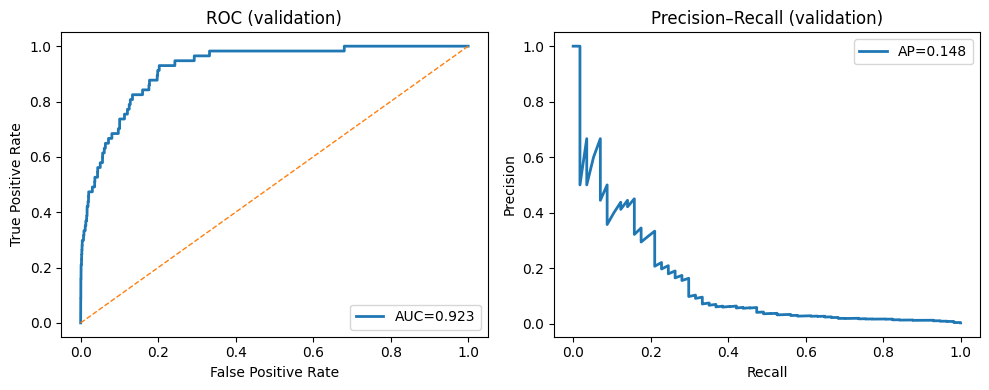

In [ ]:
# Inputs:
y_true = val_y_np.astype(int)                   # (N,) in {0,1}
p_prob = sigmoid(val_logits_np).astype(float)   # (N,) probability of class 1

P, R, T = precision_recall_curve(y_true, p_prob)
F1 = 2*P*R/(P+R+1e-12)
best_idx = np.nanargmax(F1[:-1])                # last 'T' has no point
best_thr = float(T[best_idx])
y_pred = (p_prob >= best_thr).astype(int)

# Confusion-derived stats:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp + 1e-12)

# Scalar metrics:
metrics = {
    "threshold(F1*)": best_thr,
    "accuracy": accuracy_score(y_true, y_pred),
    "precision": precision_score(y_true, y_pred, zero_division=0),
    "recall": recall_score(y_true, y_pred, zero_division=0),
    "f1": f1_score(y_true, y_pred, zero_division=0),
    "specificity": specificity,
    "balanced_acc": balanced_accuracy_score(y_true, y_pred),
    "mcc": matthews_corrcoef(y_true, y_pred),
    "roc_auc_overall": roc_auc_score(y_true, p_prob),
    "pr_auc_overall": average_precision_score(y_true, p_prob),
}

# Per-class & macro ROC/PR AUC (binary: class-vs-rest):
roc_auc_pos = roc_auc_score(y_true, p_prob)                    # class 1 vs rest
roc_auc_neg = roc_auc_score(1 - y_true, 1 - p_prob)            # class 0 vs rest
pr_auc_pos  = average_precision_score(y_true, p_prob)          # class 1
pr_auc_neg  = average_precision_score(1 - y_true, 1 - p_prob)  # class 0

metrics.update({
    "roc_auc_per_class": {"class_0": float(roc_auc_neg), "class_1": float(roc_auc_pos)},
    "roc_auc_macro": float(0.5 * (roc_auc_pos + roc_auc_neg)),
    "pr_auc_per_class":  {"class_0": float(pr_auc_neg),  "class_1": float(pr_auc_pos)},
    "pr_auc_macro":  float(0.5 * (pr_auc_pos + pr_auc_neg)),
})

print("\n=== Validation metrics @ best F1 threshold ===")
for k,v in metrics.items():
    if isinstance(v, float):
        print(f"{k:>20s}: {v:0.3f}")
    else:
        print(f"{k:>20s}: {v}")

print("\nConfusion Matrix (rows=actual, cols=pred):")
print(np.array([[tn, fp],[fn, tp]]))
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))

# Curves:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# ROC:
fpr, tpr, _ = roc_curve(y_true, p_prob)
ax1.plot(fpr, tpr, lw=2, label=f"AUC={metrics['roc_auc_overall']:.3f}")
ax1.plot([0,1],[0,1],'--',lw=1)
ax1.set_xlabel("False Positive Rate"); ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC (validation)"); ax1.legend()

# PR:
ax2.plot(R, P, lw=2, label=f"AP={metrics['pr_auc_overall']:.3f}")
ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
ax2.set_title("Precision–Recall (validation)"); ax2.legend()

plt.tight_layout(); plt.show()


**Summary Highlights:**

* The data is extremely imbalanced: about 57 intake windows vs ~21K non-intake on validation, so accuracy alone (0.997) is not very meaningful.
* At the chosen operating point (threshold &asymp; 0.36), the TCN
  * Correctly flags about 21% of intake windows (recall 0.21)
  * And when it does say “intake,” it is right about one third of the time (precision 0.33).
* For the background class, it is almost perfect: ~99.9% of non-intake windows are correctly rejected.
* The ROC AUC &asymp; 0.92 shows that the model can rank intake vs non-intake windows quite well overall.
* However, the PR AUC for intake is only ~0.15, which confirms that, under this heavy imbalance, the TCN is a weak detector on its own and mainly useful as a noisy signal, especially compared to the stronger 3D CNN.

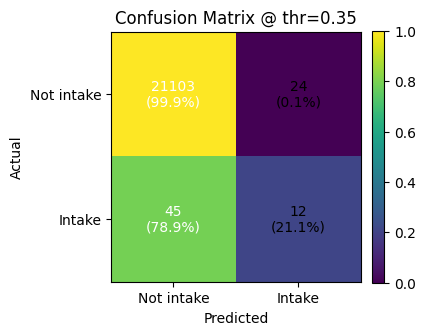

In [ ]:
# Confusion matrix heatmap:
probs = 1.0 / (1.0 + np.exp(-val_logits_np))
preds = (probs >= thr).astype(int)

tn = int(((preds==0) & (val_y_np==0)).sum())
fp = int(((preds==1) & (val_y_np==0)).sum())
fn = int(((preds==0) & (val_y_np==1)).sum())
tp = int(((preds==1) & (val_y_np==1)).sum())

cm = np.array([[tn, fp],
               [fn, tp]], dtype=float)
row_sum = cm.sum(axis=1, keepdims=True).clip(1)
cm_norm = cm / row_sum

fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1,3,1)
im = ax1.imshow(cm_norm, vmin=0, vmax=1)
ax1.set_title(f"Confusion Matrix @ thr={thr:.2f}")
ax1.set_xlabel("Predicted"); ax1.set_ylabel("Actual")
ax1.set_xticks([0,1]); ax1.set_xticklabels(["Not intake","Intake"])
ax1.set_yticks([0,1]); ax1.set_yticklabels(["Not intake","Intake"])
for i in range(2):
    for j in range(2):
        ax1.text(j, i, f"{int(cm[i,j])}\n({cm_norm[i,j]*100:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white' if cm_norm[i,j] > 0.5 else 'black')
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

**Summary Highlights:**

* At this threshold, the TCN is excellent at rejecting non-intake windows: about 99.9% of “not intake” are correctly labeled.
* It is weak at catching intake windows: it only detects about 21% of true intake windows, missing roughly 4 out of 5 bites.

No GT intake segments found in segs_ix for val keys — deriving GT from window labels.
GT segments counted: 13
[Event] best-F1 @ thr=0.31  P=0.167  R=0.308  F1=0.216 | TP=4 FP=20 FN=9
[Event] at window-thr=0.36  P=0.190  R=0.308  F1=0.235 | TP=4 FP=17 FN=9


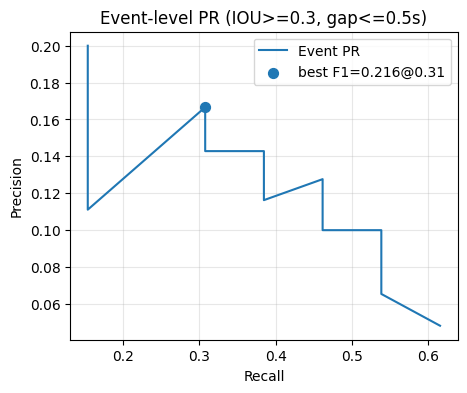

In [ ]:
# Event-level evaluation:

WIN_SEC   = float(CONFIG.get("win_sec", 2.0))
STRIDE_S  = float(CONFIG.get("stride_sec", 0.5))
IOU_THR   = 0.30
MERGE_GAP = STRIDE_S

# Helpers:
def intervals_iou(a, b):
    s1,e1=a; s2,e2=b
    inter = max(0.0, min(e1,e2)-max(s1,s2))
    union = max(e1,e2)-min(s1,s2)
    return 0.0 if union<=0 else inter/union

def merge_windows_to_events(df_key, mask_col, score_col=None, gap=MERGE_GAP):
    """Merge consecutive rows where mask_col==True into (start,end,score=max(score_col)) events."""
    g = df_key[df_key[mask_col]].sort_values("w0")[["w0","w1"] + ([score_col] if score_col else [])].to_numpy()
    ev=[];
    if len(g)==0: return ev
    s,e = float(g[0,0]), float(g[0,1])
    sc  = float(g[0,2]) if score_col else 1.0
    for row in g[1:]:
        w0,w1 = float(row[0]), float(row[1])
        p     = float(row[2]) if score_col else 1.0
        if w0 <= e + gap:
            e  = max(e, w1)
            sc = max(sc, p)
        else:
            ev.append((s,e,sc))
            s,e,sc = w0,w1,p
    ev.append((s,e,sc))
    return ev

def canonicalize_window_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    start_cands = ["w0","win_start","start_sec","start","t0","begin"]
    end_cands   = ["w1","win_end","end_sec","end","t1","stop"]
    s = next((c for c in start_cands if c in df.columns), None)
    e = next((c for c in end_cands   if c in df.columns), None)
    if s and e:
        df = df.rename(columns={s:"w0", e:"w1"})
    else:
        center_cands = ["center_sec","t","mid_sec"]
        c = next((c for c in center_cands if c in df.columns), None)
        if c is None:
            raise KeyError(f"Cannot find window columns. Columns: {list(df.columns)}")
        df["w0"] = df[c] - WIN_SEC/2
        df["w1"] = df[c] + WIN_SEC/2
    # clean
    df["w0"] = df["w0"].astype(float); df["w1"] = df["w1"].astype(float)
    df = df[df["w1"] > df["w0"]].reset_index(drop=True)
    return df

def collect_gt_from_segs_ix(val_keys) -> dict:
    """Read GT intake segments from segs_ix with flexible column names/labels."""
    df = segs_ix.copy()
    # key column
    if "key" not in df.columns:
        raise KeyError("segs_ix must have a 'key' column.")
    # start/end
    s_cands = ["start_sec","start","t0","begin"]; e_cands = ["end_sec","end","t1","stop"]
    s = next((c for c in s_cands if c in df.columns), None)
    e = next((c for c in e_cands if c in df.columns), None)
    if not (s and e):
        return {}

    df = df.rename(columns={s:"start_sec", e:"end_sec"})
    # label positivity:
    lab_col = next((c for c in ["label","event","class","type","y"] if c in df.columns), None)
    if lab_col is None:
        pos_mask = np.ones(len(df), dtype=bool)
    else:
        v = df[lab_col]
        if v.dtype == object:
            vv = v.astype(str).str.lower().str.strip()
            pos_mask = vv.isin({"1","intake","bite","sip","positive","pos"})
        else:
            pos_mask = (v.astype(float) == 1.0)
    df = df[pos_mask & df["key"].isin(val_keys)]
    gt = {}
    for k, g in df.groupby("key"):
        gt[k] = [(float(r.start_sec), float(r.end_sec)) for r in g.itertuples(index=False)]
    return gt

def pr_from_threshold(pred_events_by_key, gt_by_key, thr, iou_thr=IOU_THR):
    TP=FP=FN=0
    for k in gt_by_key.keys() | pred_events_by_key.keys():
        pred = [(s,e,sc) for (s,e,sc) in pred_events_by_key.get(k, []) if sc >= thr]
        gt   = gt_by_key.get(k, [])
        used = np.zeros(len(gt), dtype=bool)
        # sort by score
        pred = sorted(pred, key=lambda t: t[2], reverse=True)
        for (ps,pe,sc) in pred:
            j_best, best = -1, 0.0
            for j,(gs,ge) in enumerate(gt):
                if used[j]: continue
                iou = intervals_iou((ps,pe),(gs,ge))
                if iou > best: best, j_best = iou, j
            if best >= iou_thr:
                TP += 1; used[j_best] = True
            else:
                FP += 1
        FN += int((~used).sum())
    prec = TP/(TP+FP+1e-9); rec = TP/(TP+FN+1e-9); f1 = 2*prec*rec/(prec+rec+1e-9)
    return prec, rec, f1, TP, FP, FN

# Build VAL with probs (order aligned to val loader subset):
VAL = windows_df[windows_df["split"]=="val"].reset_index(drop=True).copy()
VAL = canonicalize_window_cols(VAL)
VAL["prob"] = 1.0 / (1.0 + np.exp(-val_logits_np))

val_keys = VAL["key"].unique().tolist()

# Getting GT from segs_ix; fall back to windows_df positives if empty:
GT_MAP = collect_gt_from_segs_ix(val_keys)
total_gt = sum(len(v) for v in GT_MAP.values())

if total_gt == 0:
    print("No GT intake segments found in segs_ix for val keys — deriving GT from window labels.")
    assert "label" in VAL.columns, "VAL needs a 'label' column to derive GT."
    GT_MAP = {}
    for k, g in VAL.groupby("key"):
        g = g.sort_values("w0")
        g["is_pos"] = (g["label"].astype(int) == 1)
        GT_MAP[k] = [(s,e) for (s,e,_) in merge_windows_to_events(g, "is_pos", score_col=None, gap=MERGE_GAP)]

print(f"GT segments counted: {sum(len(v) for v in GT_MAP.values())}")

# Build predicted events per key using probabilities (score=max prob):
PRED_MAP = {}
for k, g in VAL.groupby("key"):
    g = g.sort_values("w0")
    g["is_pos_win"] = True  # we'll threshold later; here we just merge all windows using prob to set scores
    # merge only windows with prob >= minimal sweep start to reduce junk
    g["is_pos_win"] = g["prob"] >= 0.05
    PRED_MAP[k] = merge_windows_to_events(g, "is_pos_win", score_col="prob", gap=MERGE_GAP)

# Sweep thresholds -> PR curve:
grid = np.linspace(0.05, 0.80, 30)
PR   = [pr_from_threshold(PRED_MAP, GT_MAP, thr=t, iou_thr=IOU_THR) for t in grid]
prec = np.array([p for p,_,_,_,_,_ in PR]); rec = np.array([r for _,r,_,_,_,_ in PR]); f1s = np.array([f for *_, f, _, _, _ in PR])

best_i = int(f1s.argmax())
best_thr_event = float(grid[best_i])
best_prec, best_rec, best_f1, TP, FP, FN = PR[best_i]

print(f"[Event] best-F1 @ thr={best_thr_event:.2f}  P={best_prec:.3f}  R={best_rec:.3f}  F1={best_f1:.3f} | TP={TP} FP={FP} FN={FN}")
ref_prec, ref_rec, ref_f1, TP2, FP2, FN2 = pr_from_threshold(PRED_MAP, GT_MAP, thr=float(best_thr), iou_thr=IOU_THR)
print(f"[Event] at window-thr={best_thr:.2f}  P={ref_prec:.3f}  R={ref_rec:.3f}  F1={ref_f1:.3f} | TP={TP2} FP={FP2} FN={FN2}")

# Plot Event PR:
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label="Event PR")
plt.scatter([best_rec], [best_prec], s=50, label=f"best F1={best_f1:.3f}@{best_thr_event:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Event-level PR (IOU>={IOU_THR}, gap<={MERGE_GAP}s)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


**Summary Highlights:**

* There are 13 ground truth intake events on validation.
* At the best event threshold (~0.31), the TCN finds 4 events and misses 9, with precision about 17% and recall about 31% (F1 &asymp; 0.22).
* Tightening the threshold (0.36) keeps recall the same (still 4 of 13) and only slightly reduces false alarms, so overall event-level detection is weak and noisy.